In [1]:
# Desinstalar posibles conflictos
!pip uninstall -y tensorflow tensorflow-probability tf-agents tf-agents-nightly

# Instalar versiones compatibles
!pip install tensorflow==2.13.0
!pip install tensorflow-probability==0.21.0
!pip install tf-agents==0.17.0
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay pyglet swig
!pip install gym[atari,box2d,accept-rom-license]
!pip install gym-super-mario-bros

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: tensorflow-probability 0.25.0
Uninstalling tensorflow-probability-0.25.0:
  Successfully uninstalled tensorflow-probability-0.25.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.2/524.2 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 19.2 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.14.0
    Uninstalling typing_extensions-4.14.0:
      Successfully uninstalled typing_extensions-4.14.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successful

In [2]:
import os
import numpy as np
import tensorflow as tf
import gym
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from nes_py.wrappers import JoypadSpace
from gym.wrappers import GrayScaleObservation, ResizeObservation, FrameStack
from IPython.display import HTML
from base64 import b64encode
import imageio
from pyvirtualdisplay import Display

from tf_agents.environments import gym_wrapper, tf_py_environment
from tf_agents.networks.q_network import QNetwork
from tf_agents.agents.dqn.dqn_agent import DqnAgent
from tf_agents.utils import common
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.policies import policy_saver

# Iniciar display virtual para renderizado en video
display = Display(visible=0, size=(1400, 900))
display.start()

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 304, in register_gymnasium_envs
    _register_atari_envs()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 244, in _register_atari_envs
    _register_atari_configs(
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 168, in _register_atari_configs
    from ale_py.roms import utils as rom_utils
ImportError: cannot import name 'utils' from 'ale_py.roms' (/usr/local/lib/python3.11/dist-packages/ale_py/roms/__init__.py)

  logger.warn(f"plugin: {plugin.value} raised {traceback.format_exc()}")


In [3]:
class CustomRewardMario(gym.Wrapper):
    def __init__(self, env):
        super(CustomRewardMario, self).__init__(env)
        self.prev_x = 0
        self.stuck_counter = 0

    def reset(self, **kwargs):
        self.prev_x = 0
        self.stuck_counter = 0
        return self.env.reset(**kwargs)

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        x_pos = info.get("x_pos", 0)

        # Penalizar retroceso significativo
        if x_pos < self.prev_x - 5:
            reward -= 10

        # Penalizar estancamiento si no avanza
        if abs(x_pos - self.prev_x) < 1:
            self.stuck_counter += 1
            if self.stuck_counter >= 15:
                reward -= 10
        else:
            self.stuck_counter = 0

        self.prev_x = x_pos
        return obs, reward, done, info

In [4]:
def create_mario_env(version="v1"):
    env = gym_super_mario_bros.make(f"SuperMarioBros-{version}")
    env = JoypadSpace(env, SIMPLE_MOVEMENT)
    env = CustomRewardMario(env)  # Wrapper que ajusta recompensas
    env = GrayScaleObservation(env, keep_dim=True)
    env = ResizeObservation(env, 84)
    env = FrameStack(env, 4)
    return gym_wrapper.GymWrapper(env)

train_py_env = create_mario_env("v1")
eval_py_env = create_mario_env("v1")
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment SuperMarioBros-v1 is out of date. You should consider upgrading to version `v3` with the environment ID `SuperMarioBros-v3`.
  logger.warn(


In [5]:
conv_layer_params = [(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params = [512]
preprocessing_layer = tf.keras.layers.Lambda(lambda obs: tf.cast(obs, tf.float32) / 255.0)

q_net = QNetwork(
    input_tensor_spec=train_env.observation_spec(),
    action_spec=train_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params,
)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=2.5e-4, rho=0.95, momentum=0.0, epsilon=0.01)
train_step_counter = tf.Variable(0)

agent = DqnAgent(
    time_step_spec=train_env.time_step_spec(),
    action_spec=train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter,
    gamma=0.99,
    epsilon_greedy=0.1,
    target_update_period=1000,
)
agent.initialize()

In [6]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=100000,
)

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec())

def collect_step(env, policy, buffer):
    time_step = env.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = env.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    buffer.add_batch(traj)

# Rellenar el buffer inicialmente con acciones aleatorias
for _ in range(2000):
    collect_step(train_env, random_policy, replay_buffer)

# Dataset de entrenamiento
reward_history = []  # Lista para guardar recompensa media por iteración

# Dataset desde el replay buffer
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=32, num_steps=2
).prefetch(3)
iterator = iter(dataset)

print("*----------Inicio de entrenamiento-----------")
# Bucle de entrenamiento
for iteration in range(120000):
    collect_step(train_env, agent.collect_policy, replay_buffer)
    experience, _ = next(iterator)
    train_loss = agent.train(experience).loss

    # Registrar recompensa promedio del batch
    reward = experience.reward.numpy().mean()
    reward_history.append(reward)

    # Mostrar progreso
    if iteration % 500 == 0:
        print(f"🔁 Iteración {iteration}: pérdida = {train_loss:.4f}, recompensa promedio = {reward:.2f}")
        
checkpoint_dir = '/kaggle/working/mario_dqn_checkpoint512'
policy_saver.PolicySaver(agent.policy).save(checkpoint_dir)
print(f"💾 Agente guardado en: {checkpoint_dir}")

*----------Inicio de entrenamiento-----------
🔁 Iteración 0: pérdida = 50.9319, recompensa promedio = -4.52
🔁 Iteración 500: pérdida = 16.3265, recompensa promedio = -4.06
🔁 Iteración 1000: pérdida = 37.6393, recompensa promedio = -4.22
🔁 Iteración 1500: pérdida = 20.9541, recompensa promedio = -2.77
🔁 Iteración 2000: pérdida = 32.5005, recompensa promedio = -4.05
🔁 Iteración 2500: pérdida = 7.7741, recompensa promedio = -2.58
🔁 Iteración 3000: pérdida = 32.6453, recompensa promedio = -3.78
🔁 Iteración 3500: pérdida = 8.6379, recompensa promedio = -3.09
🔁 Iteración 4000: pérdida = 28.0598, recompensa promedio = -3.25
🔁 Iteración 4500: pérdida = 5.3137, recompensa promedio = -1.56
🔁 Iteración 5000: pérdida = 29.3487, recompensa promedio = -3.72
🔁 Iteración 5500: pérdida = 16.5557, recompensa promedio = -2.08
🔁 Iteración 6000: pérdida = 39.6292, recompensa promedio = -2.55
🔁 Iteración 6500: pérdida = 15.3750, recompensa promedio = -2.31
🔁 Iteración 7000: pérdida = 18.1098, recompensa pro

/usr/local/lib/python3.11/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:475: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


💾 Agente guardado en: /kaggle/working/mario_dqn_checkpoint512


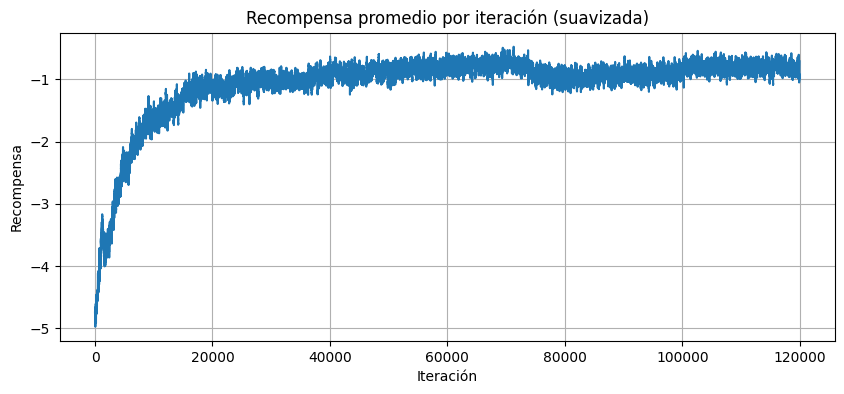

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_rewards(reward_history, smooth=50):
    rewards = np.array(reward_history)
    if smooth > 1:
        kernel = np.ones(smooth) / smooth
        rewards = np.convolve(rewards, kernel, mode="valid")

    plt.figure(figsize=(10, 4))
    plt.plot(rewards)
    plt.title("Recompensa promedio por iteración (suavizada)")
    plt.xlabel("Iteración")
    plt.ylabel("Recompensa")
    plt.grid(True)
    plt.show()
    
plot_rewards(reward_history)

In [8]:
import imageio
import numpy as np
import tensorflow as tf
import gym
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from nes_py.wrappers import JoypadSpace

def record_mario_video(agent, max_steps=500, fps=30, filename='mario_fixed512.mp4'):

    env = gym_super_mario_bros.make("SuperMarioBros-v1")  # SIN render_mode
    env = JoypadSpace(env, SIMPLE_MOVEMENT)

    obs = env.reset()
    dummy_time_step = train_env.reset()
    frames = []
    total_reward = 0

    for step in range(max_steps):
        try:
            frames.append(env.screen.copy())
        except:
            continue

        obs_proc = np.expand_dims(obs, axis=0).astype(np.uint8)
        obs_proc = tf.image.rgb_to_grayscale(obs_proc)
        obs_proc = tf.image.resize(obs_proc, (84, 84))
        obs_proc = tf.cast(obs_proc, tf.uint8)
        obs_proc = tf.stack([obs_proc] * 4, axis=1)

        time_step = dummy_time_step._replace(observation=obs_proc)
        action_step = agent.policy.action(time_step)
        action = int(action_step.action.numpy()[0])

        obs, reward, done, _ = env.step(action)
        total_reward += reward

        if done:
            break

    env.close()
    output_path = f"/kaggle/working/{filename}"
    imageio.mimsave(output_path, frames, fps=fps)
    print(f"🎥 Video guardado en: {output_path} | Recompensa total: {total_reward:.2f}")
    return output_path

# Grabar y Guardar el video
video_path = record_mario_video(agent, max_steps=1500, filename="mario_v1_episode512.mp4")

/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment SuperMarioBros-v1 is out of date. You should consider upgrading to version `v3` with the environment ID `SuperMarioBros-v3`.
  logger.warn(


🎥 Video guardado en: /kaggle/working/mario_v1_episode512.mp4 | Recompensa total: 462.00
